In [7]:

import torch

import os 
import numpy as np
from PIL import Image
import numbers
import random


In [8]:
import pandas as pd
from skimage import io, transform
import torch
from torch.utils.data import Dataset , DataLoader
import os
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [9]:
class modified_dataset(Dataset):
    def __init__(self, csv_file, root, T = None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root = root
        self.T = T
    def __len__(self):
        return len(self.landmarks_frame)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx.tolist()
        imgname = os.path.join(self.root,self.landmarks_frame.iloc[idx,0])
        image = io.imread(imgname)
        landmarks = self.landmarks_frame.iloc[idx,1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image':image , 'landmarks':landmarks}
        if self.T:
            sample = self.T(sample)
        return sample , imgname , idx

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
class RandomRotation(object):
    """Rotate the image by angle.

    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter. See `filters`_ for more information.
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.

    .. _filters: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters

    """

    def __init__(self, degrees, resample=None, expand=True, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.

        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Image to be rotated.

        Returns:
            PIL Image: Rotated image.
        """

        angle = self.get_params(self.degrees)
        img = sample['image']
        landmarks = sample ['landmarks']
        
        images = transform.rotate(img, angle, resize=False, center=None, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
        
        ##ROTATE THE FEATURES USING ROTATION MATRIX
        landmarks_copy= landmarks.copy()

        landmarks_copy[:,0] =  landmarks_copy[:,0] - img.shape[1]/2
        landmarks_copy[:,1]  = landmarks_copy[:,1] -  img.shape[0]/2

        rot_matrix = np.array(([np.cos(np.radians(angle)), -np.sin(np.radians(angle))],[np.sin(np.radians(angle)), np.cos(np.radians(angle))] ))
        landmarks_copy= np.matmul(landmarks_copy , rot_matrix)

        landmarks_copy[:,0] =  landmarks_copy[:,0] + img.shape[1]/2
        landmarks_copy[:,1]  = landmarks_copy[:,1] + img.shape[0]/2
        landmarks_copy=np.delete(landmarks_copy, np.where(landmarks_copy <= 0)[0], axis=0)
        landmarks_copy=np.delete(landmarks_copy, np.where(landmarks_copy <= 0)[1], axis=0)
        landmarks_copy=np.delete(landmarks_copy, np.where(landmarks_copy >= img.shape[1])[0], axis=0)
        landmarks_copy=np.delete(landmarks_copy, np.where(landmarks_copy >= img.shape[0])[1], axis=0)
        size = landmarks.shape[0] - landmarks_copy.shape[0]

        b = np.zeros([size,2])

        for i in range (size):
            b[i:] = None

        landmarks_copy = np.vstack((landmarks_copy,b))


        return {'image':images , 'landmarks': landmarks_copy}

    
class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img,target):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return F.hflip(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)    
    
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

    
    
def show_landmarks_batch(sampled_batch):
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

In [10]:
# landmarks_frame = pd.read_csv('/home/ashish95/Pictures/Dataset/faces/landmarks/face_landmarks.csv')
# imagename = landmarks_frame.iloc[13,0] 
# image = io.imread ('/home/ashish95/Pictures/Dataset/faces/Image_folder/Images/'+ str(imagename))
# print(image.shape)

# landmarks = np.array([landmarks_frame.iloc[13,1:]])
# landmarks = landmarks.astype('float').reshape(-1,2)

# #landmarks = np.array(([image.shape[1],image.shape[0]]))-landmarks

# landmarks_modified = landmarks.copy() 
# landmarks_copy= landmarks.copy()
# landmarks_copy[:,0] =  landmarks_copy[:,0] - image.shape[1]/2
# landmarks_copy[:,1]  = landmarks_copy[:,1] -  image.shape[0]/2

# rot_matrix = np.array(([np.cos(np.radians(60)), -np.sin(np.radians(60))],[np.sin(np.radians(60)), np.cos(np.radians(60))] ))
# landmarks_copy= np.matmul(landmarks_copy , rot_matrix)
# landmarks_copy2= landmarks_copy.copy()
# landmarks_copy[:,0] =  landmarks_copy[:,0] + image.shape[1]/2
# landmarks_copy[:,1]  = landmarks_copy[:,1] + image.shape[0]/2


# landmarks_copy = np.delete(landmarks_copy, np.where(landmarks_copy <= 0)[0], axis=0)
# landmarks_copy = np.delete(landmarks_copy, np.where(landmarks_copy <= 0)[1], axis=0)
# landmarks_copy = np.delete(landmarks_copy, np.where(landmarks_copy >= image.shape[1])[0], axis=0)
# landmarks_copy = np.delete(landmarks_copy, np.where(landmarks_copy >= image.shape[0])[1], axis=0)


# # landmarks_copy2[np.column_stack((np.where(landmarks_copy2 <= 0)[0] ,np.where(landmarks_copy2 <= 0)[1]))] = None
# # landmarks_copy2[np.column_stack((np.where(landmarks_copy2 >= image.shape[1])[0] ,np.where(landmarks_copy2 >= image.shape[0])[1]))] = None


# # landmarks_copy [:,0] = (landmarks[:,0])* np.cos(np.radians(60)) - (landmarks[:,1])* np.sin(np.radians(60))
# # landmarks_copy [:,1] = (landmarks[:,0])* np.sin(np.radians(60)) + (landmarks[:,1])* np.cos(np.radians(60))
# #landmarks_copy.astype('int')

# #print(landmarks)
# #landmarks_transform = transform.rotate(landmarks, 60, resize=False, center=None, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
# # print(landmarks_modified.astype('int'))
# # print(landmarks_transform)

# # print(landmarks_copy.astype('int'))

# plt.imshow(transform.rotate(image, 60))
# plt.scatter(landmarks_copy[:, 0], landmarks_copy[:, 1], s=10, marker='.', c='w')
# plt.show()

# plt.imshow(image)
# plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='w')
# plt.show()

# landmarks

In [11]:
# test = modified_dataset('/home/ashish95/Pictures/Dataset/faces/face_landmarks.csv','/home/ashish95/Pictures/Dataset/faces/')
# # sample = test[1]
# # plt.imshow(sample['image'])
# # plt.scatter(sample['landmarks'][:,0],sample['landmarks'][:,1], marker= '.' , c='y')
# # plt.show()

# # test[1]
# # test.landmarks_frame

# Trfs = transforms.Compose([ 
#                    #                transforms.RandomRotation(60),
#                                    transforms.ToTensor(),
                                    
#                                  ]) 

# # dataset = modified_dataset('/home/ashish95/Pictures/Dataset/faces/face_landmarks.csv','/home/ashish95/Pictures/Dataset/faces/', Trfs)
# # dataloaders=DataLoader(dataset , shuffle=True, batch_size=3 , num_workers=1)
# sample = test[1]
# scale = Rescale(256)
# crop = RandomCrop(128)
# composed = transforms.Compose([Rescale(256),
#                                RandomCrop(224)])

# tsfrm1 = transforms.Compose([RandomRotation(60)])

# # Apply each of the above transforms on sample.
# fig = plt.figure()
# for i, tsfrm in enumerate([scale, crop, composed]):
#     transformed_sample = tsfrm(sample)

#     ax = plt.subplot(1, 3, i + 1)
#     plt.tight_layout()
#     ax.set_title(type(tsfrm).__name__)
#     show_landmarks(**transformed_sample)

# plt.show()

# plt.figure()
# transformed_sample = tsfrm1(sample)    
# show_landmarks(**transformed_sample)
# plt.show()




# T = {'Train': transforms.Compose([ transforms.RandomHorizontalFlip(),
#                                    transforms.ToTensor()
                                          
#                                  ]) ,
      
#     'valid': transforms.Compose([   
#                                    transforms.RandomHorizontalFlip(),
#                                    transforms.ToTensor(),
#                                    transforms.Normalize([0.596, 0.436, 0.586], [0.2066, 0.240, 0.186])       
#                                  ]) ,
      
#     'Test': transforms.Compose([ transforms.RandomHorizontalFlip(),
#                                    transforms.ToTensor(),
#                                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))       
#                                  ]) 
#     }


Trfs = transforms.Compose([        
                                   Rescale(256),
                                   RandomCrop(224),
                                   RandomRotation(10),
                                   ToTensor()
                                   #transforms.Normalize([0.596, 0.436, 0.586], [0.2066, 0.240, 0.186])       
                                 ]) 
#root ='/home/ashish95/Pictures/Dataset/CoNSeP/'
#dataset = {x: Hist_Dataset(root_dir = os.path.join(root,x),transform = T[x]) for x in ['Train', 'Test']}
dataset = modified_dataset('/home/ashish95/Pictures/Dataset/faces/landmarks/face_landmarks.csv','/home/ashish95/Pictures/Dataset/faces/Image_folder/Images/', T=Trfs)

#dataloaders={x : DataLoader(dataset[x] , shuffle=True, batch_size=3 , num_workers=1) for x in ['Train', 'Test']}
dataloaders=DataLoader(dataset , shuffle=True, batch_size=4 , num_workers=4)


0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
('/home/ashish95/Pictures/Dataset/faces/Image_folder/Images/3646828311_bfeb429ef7.jpg', '/home/ashish95/Pictures/Dataset/faces/Image_folder/Images/3534188114_2108895291.jpg', '/home/ashish95/Pictures/Dataset/faces/Image_folder/Images/2327253037_66a61ea6fe.jpg', '/home/ashish95/Pictures/Dataset/faces/Image_folder/Images/299733036_fff5ea6f8e.jpg')
tensor([49, 42, 15, 30])


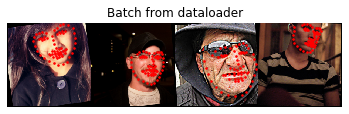

In [5]:
for i in range(len(dataset)):
    sample , address , idx = dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
     
    if i == 3:
        break
    
for i_batch, sample in enumerate(dataloaders):
    sample_batched , address , idx = sample
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    
    if i_batch == 2:
        print(address)
        print(idx)
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

    

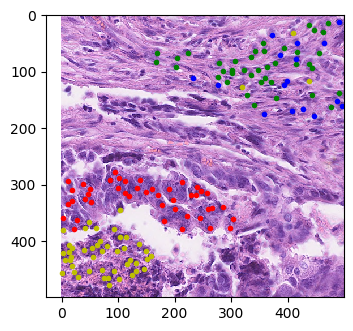

In [44]:
from scipy.io import loadmat
root='/home/ashish95/Pictures/Dataset/crchistophenotypes_2016_04_28/CRCHistoPhenotypes_2016_04_28/Classification/img43/'
os.listdir(root)

e = loadmat(os.path.join(root,os.listdir(root)[1]))
f = loadmat(os.path.join(root,os.listdir(root)[2]))
i = loadmat(os.path.join(root,os.listdir(root)[3]))
o = loadmat(os.path.join(root,os.listdir(root)[4]))
image = io.imread(os.path.join(root,os.listdir(root)[0]))

e_r,e_c = e['detection'].shape
f_r,f_c = f['detection'].shape
i_r,i_c = i['detection'].shape
o_r,o_c = o['detection'].shape

Ann = np.vstack((e['detection'],f['detection'],i['detection'],o['detection']))


Ann.shape

# image= io.imread('/home/ashish95/Pictures/Dataset/crchistophenotypes_2016_04_28/CRCHistoPhenotypes_2016_04_28/Classification/img43/img43.bmp')
# #plt.imsave('Test.bmp')
# image.shape

plt.figure(figsize=(3.841, 7.195), dpi=100)
plt.imshow(image)
plt.scatter(Ann[:e_r,0],Ann[:e_r,1], marker= '.' , c='r')
plt.scatter(Ann[e_r:e_r+f_r,0],Ann[e_r:e_r+f_r,1], marker= '.' , c='g')
plt.scatter(Ann[e_r+f_r:e_r+f_r+i_r,0],Ann[e_r+f_r:e_r+f_r+i_r,1], marker= '.' , c='b')
plt.scatter(Ann[e_r+f_r+i_r:e_r+f_r+i_r+o_r,0],Ann[e_r+f_r+i_r:e_r+f_r+i_r+o_r,1], marker= '.' , c='y')

#plt.scatter(Ann[:,0],Ann[:,1], marker= '.' , c='r')
#plt.savefig('myfig.png', dpi=1000)
plt.show()

In [3]:
import os
from scipy.io import loadmat
from skimage import io
root='/home/ashish95/Pictures/Dataset/crchistophenotypes_2016_04_28/CRCHistoPhenotypes_2016_04_28/Detection//img43/'
os.listdir(root)

det = loadmat(os.path.join(root,os.listdir(root)[1]))
# f = loadmat(os.path.join(root,os.listdir(root)[2]))
# i = loadmat(os.path.join(root,os.listdir(root)[3]))
# o = loadmat(os.path.join(root,os.listdir(root)[4]))
image = io.imread(os.path.join(root,os.listdir(root)[0]))

print(det['detection'])
det_r,det_c = det['detection'].shape

plt.figure(figsize=(3.841, 7.195), dpi=100)
plt.imshow(image)
plt.scatter(det['detection'][:,0],det['detection'][:,1], marker= '.' , c='r')
plt.show()

print(e_r,e_c)
print(f_r,f_c)
print(i_r,i_c)
print(o_r,o_c)
print(det_r,det_c)


[[1.88058336e+01 3.28838178e+02]
 [1.11343534e+01 3.35155868e+02]
 [5.26689834e+01 3.30425078e+02]
 [4.09361314e+01 3.25461179e+02]
 [4.59000303e+01 3.15984644e+02]
 [4.99614021e+01 3.07410637e+02]
 [3.73260231e+01 2.99287894e+02]
 [1.83729545e+01 3.08764428e+02]
 [1.16040014e+01 2.92970204e+02]
 [2.73982252e+01 3.62013525e+02]
 [1.67620357e+00 3.59305944e+02]
 [2.10805357e+01 3.78259013e+02]
 [1.19004723e+02 3.20948543e+02]
 [1.32993893e+02 3.06056847e+02]
 [1.11333243e+02 2.93872731e+02]
 [1.11333243e+02 3.14630854e+02]
 [1.00502918e+02 3.05605583e+02]
 [1.01405445e+02 2.87555042e+02]
 [9.50877559e+01 2.77175980e+02]
 [8.56112216e+01 2.91616413e+02]
 [1.59618442e+02 3.06959374e+02]
 [1.49239380e+02 3.13728327e+02]
 [1.38409056e+02 2.91616413e+02]
 [1.70900030e+02 3.19143489e+02]
 [1.77668983e+02 3.35840240e+02]
 [1.81730355e+02 3.64269843e+02]
 [1.97975843e+02 3.28168760e+02]
 [1.90755626e+02 3.06959374e+02]
 [2.01134687e+02 3.43962984e+02]
 [2.62521775e+02 3.77186428e+02]
 [2.458250

NameError: name 'plt' is not defined

# CUSTOM DATASET

In [ ]:
import os 
import numpy as np
import torch


In [ ]:
from torch.utils.data import Dataset,DataLoader
from skimage import io
import torchvision.transforms as transforms
from PIL import Image
#im = Image.open("bride.jpg")

In [ ]:

# root='/home/ashish95/Pictures/Dataset/CoNSeP/Train/'

# root_list = os.listdir(root)
# labels_list = os.listdir(os.path.join(root,os.listdir(root)[0]))
# image_list = os.listdir(os.path.join(root,os.listdir(root)[1]))
# np.load(root+root_list[0]+'/'+labels_list[0])

# io.imshow(root+root_list[1]+'/'+image_list[0])

# try_ = os.path.join(root,'Train')
# xx = os.listdir(os.path.join(try_,os.listdir(try_)[1]))
#os.path.join(try_,os.listdir(try_)[1])

class Hist_Dataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root = root_dir
        self.transform = transform
        self.root_list = os.listdir(root)
        self.image_ref = os.path.join(self.root,os.listdir(self.root)[1])
        self.image_path = os.path.join(self.root,self.image_ref)
        self.image_list = os.listdir(self.image_path)
        
        self.label_ref = os.path.join(self.root,os.listdir(self.root)[0])
        self.label_path = os.path.join(self.root,self.label_ref)
        self.label_list = os.listdir(self.label_path)
        
    def __getitem__(self,idx):
        Trfs = transforms.Compose([ 
                                   transforms.Normalize([0.596, 0.436, 0.586], [0.2066, 0.240, 0.186])       
                                 ]) 
        if torch.is_tensor(idx):
            idx.tolist()
        images = Image.open(os.path.join(self.image_path,self.image_list[idx]))
        images = images.convert('RGB')
        labels = np.load(os.path.join(self.label_path,self.label_list[idx]))
        samples={}
        
        if self.transform:
            images = Trfs(self.transform(images))
            labels = self.transform(labels)
            #images = transforms.ComposeNormalize([0.596, 0.436, 0.586], [0.2066, 0.240, 0.186])
            
        samples['images'] = images
        samples['labels'] = labels
        return samples
    
    def __len__(self):
        return(len(self.image_list))
        

In [ ]:
T = {'Train': transforms.Compose([ transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()
                                          
                                 ]) ,
      
    'valid': transforms.Compose([   
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.596, 0.436, 0.586], [0.2066, 0.240, 0.186])       
                                 ]) ,
      
    'Test': transforms.Compose([   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))       
                                 ]) 
    }

# Trfs = transforms.Compose([ 
                                   
#                                    transforms.ToTensor(),
#                                    transforms.Normalize([0.596, 0.436, 0.586], [0.2066, 0.240, 0.186])       
#                                  ]) 
root ='/home/ashish95/Pictures/Dataset/CoNSeP/'
dataset = {x: Hist_Dataset(root_dir = os.path.join(root,x),transform = T[x]) for x in ['Train', 'Test']}
#dataset = Hist_Dataset(root_dir = os.path.join(root,'Train'),transform = Trfs) 
print(dataset)
#dataloaders={x : DataLoader(dataset[x] , shuffle=True, batch_size=3 , num_workers=1) for x in ['Train', 'Test']}
#dataloaders=DataLoader(dataset , shuffle=True, batch_size=3 , num_workers=1)

In [ ]:
# for i , sample in enumerate(dataloaders['Train']):
#     print(i,sample)
#     image , label = sample['images'] , sample['labels']
#     print(image)

for i in range(len(dataset['Train'])):
    sample = dataset['Train'][i]


In [ ]:
root = '/home/ashish95/Pictures/Dataset/CoNSeP/'
root = os.path.join(root,'Train')
image_ref = os.path.join(root,os.listdir(root)[1])
image_path = os.path.join(root,image_ref)
image_list = os.listdir(image_path)
io.imshow(os.path.join(image_path,image_list[0]))

In [ ]:
im=io.imread('/home/ashish95/Pictures/Dataset/CoNSeP/Train/Images/train_21.png')
im.shape
im1=im[:,:,:3]
im1.shape

#io.imshow(im1)


In [ ]:
import torchvision.datasets as dset
root = '/home/ashish95/Pictures/Dataset/faces/Image_folder/'

T  = transforms.Compose([ transforms.RandomHorizontalFlip(),
                          transforms.Resize(256),
                          transforms.RandomCrop(224),
                          transforms.RandomRotation(60),
                          transforms.ToTensor()
                                          
                        ])

dataset = dset.ImageFolder(root= root , transform=T)
dataloaders = DataLoader(dataset , batch_size=4 , shuffle=True , num_workers=4)

In [6]:
from . import functional as F
def show_batch_image(images_batch):
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i , data in enumerate (dataloaders):
    if i%4 == 0:
        plt.figure()
        show_batch_image(data[0])

ImportError: cannot import name 'functional' from '__main__' (unknown location)